# **1. VAR on the Processed Data**

We begin by importing the necessary data.  
To simplify further analysis, we preprocessed and saved a new CSV file named **`processed_data_5min.csv`**.  

This file contains computed volumes of **Limit Orders**, **Cancellations**, and **Executions** for both **bids** and **asks**, derived from the raw data in **`TOTF_book_03_04_2017.csv`** and **`TOTF_trade_03_04_2017.csv`**.


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from datetime import date, time

df = pd.read_csv("processed_data_5min.csv") 

# Cleaning the useless lines
df_clean = df.dropna()

df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# Sorting by time
df_clean = df_clean.set_index('datetime').sort_index()

/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/3414910383.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])


# **2. Stationarity Test**

In order to apply the VAR model, it is essential to test the stationarity of our data.  
To do this, we first apply the **ADF test** (Augmented Dickey-Fuller) to check whether the flows are stationary — that is, whether their statistical properties (mean, variance) remain constant over time.

To strengthen the analysis, we also apply the **KPSS test**, testing for stationarity around a **constant** (rather than around a trend).  
This is important because a standard VAR model requires that the time series be **strictly stationary**, not just trend-stationary.


In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(df: pd.DataFrame ) -> pd.DataFrame:
    """
    Test ADF (H0: unit root) et KPSS (H0: stationary)
    
    Parameters
    ----------
    df : pd.DataFrame
        Times series
    """

    results = []
    signif = 0.05 # alpha = 5%
    
    for col in df.select_dtypes("number").columns: # for each flow
            
        series = df[col].dropna()
        
        # Test ADF (H0: unit root = non-stationary)
        adf_result = adfuller(series, autolag="AIC")
        adf_p = adf_result[1]
        
        # Test KPSS (H0: stationary)
        kpss_result = kpss(series, regression="c", nlags="auto")
        kpss_p = kpss_result[1]
        
        # test with p value
        if adf_p < signif and kpss_p > signif:
            decision = "Stationary"
        elif adf_p >= signif and kpss_p <= signif:
            decision = "Non-stationary"
        else:
            # ambigous case
            if adf_p < signif and kpss_p <= signif:
                decision = "Trend-stationary"
            else: 
                decision = "Inconclusive"
                
        
        results.append({
            "Variable": col,
            "ADF_p-value": round(adf_p, 4) if adf_p is not None else None,
            "KPSS_p-value": round(kpss_p, 4) if kpss_p is not None else None,
            f"result": decision,
        })
    
    res_df = pd.DataFrame(results)

    return res_df


# Test functions : 

# Stationary data 
df_stat = pd.read_csv('Data/stationnary_data.csv')
df_stat['datetime'] = pd.to_datetime(df_stat['datetime'])

# Non-stationary data  
df_nonstat = pd.read_csv('Data/unstationnary_data.csv')
df_nonstat['datetime'] = pd.to_datetime(df_nonstat['datetime'])

results_stat = test_stationarity(df_stat)
results_nonstat = test_stationarity(df_nonstat)

print("Non-stationary data :")
print(results_nonstat)
print("")
print("Stationary data :")
print(results_stat)


Non-stationary data :
     Variable  ADF_p-value  KPSS_p-value          result
0  Vol_lo_bid       0.8138          0.01  Non-stationary
1  Vol_lo_ask       0.8138          0.01  Non-stationary
2   Vol_c_bid       0.9783          0.01  Non-stationary
3   Vol_c_ask       0.9705          0.01  Non-stationary
4  Vol_ex_bid       0.9478          0.01  Non-stationary
5  Vol_ex_ask       0.0000          0.10      Stationary

Stationary data :
     Variable  ADF_p-value  KPSS_p-value        result
0  Vol_lo_bid       0.4440           0.1  Inconclusive
1  Vol_lo_ask       0.3416           0.1  Inconclusive
2   Vol_c_bid       0.0399           0.1    Stationary
3   Vol_c_ask       0.0106           0.1    Stationary
4  Vol_ex_bid       0.0190           0.1    Stationary
5  Vol_ex_ask       0.0000           0.1    Stationary


/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.p

In the code below, we test three different methods to make our data stationary:

1. **Clipping the first day**:  
   We progressively remove early data from the first day until the stationarity test (defined above) is satisfied. This method involves iteratively trimming the data until it passes the test.

2. **Differencing up to 14:30**:  
   Based on observations from the first method, we apply first-order differencing to all data up to 14:30 — which corresponds to the opening of the U.S. markets in France.

3. **Log transformation**:  
   We also attempted a logarithmic transformation of the data. However, this method did not yield meaningful results for our dataset and was not retained.


In [7]:
def isStationnary(results_raw):

    """
    Checks whether all series in a given result set are strictly stationary.
    Returns True only if all series are classified as strictly stationary 

    """
        
    n = len(results_raw['result']) # result of test_stationarity function
    for i in range(n):
        if results_raw['result'][i]=='Trend-stationary': return False
        if results_raw['result'][i]=='Unstationnary': return False
        if results_raw['result'][i]=='Inconclusive': return False
    return True


def clip_fst_day(df_clean):

    """ 
    Iteratively filters the input DataFrame (only for the first day) to extract a strictly stationary subset.
    The function reduces the time window from the original dataset (for a specific date)
    in 5-minute steps until the stationarity condition is met for all variables.

    """


    results_raw = test_stationarity(df_clean)
    minutes = 55
    hour = 15
    while(not isStationnary(results_raw)): # we remove one data while the data clipped is not stationnary
        df_filtered = df_clean[
            (df_clean['date'] == '2017-03-13') & 
            (df_clean['time'] <= str(time(hour,minutes)))
        ]

        # in order to do that, (the data are grouped by 5 minutes) we remove at each test 5 minutes
        minutes -= 5
        
        if minutes == -5:
            hour -= 1
            minutes = 55


        results_raw = test_stationarity(df_filtered)
    
    return results_raw,df_filtered

def diff_all_days_14_30(df_clean):

    """ Filters the DataFrame up to 14:30 and applies first-order differencing 
    on all numeric columns to achieve stationarity."""

    
    df_filtered = df_clean[df_clean['time'] <= str(time(14, 30))] # result of clip_fst_day

    df_numeric = df_filtered.select_dtypes(include='number')
    
    df_diffed = df_numeric.diff().dropna() # we diff only one time

    results_raw = test_stationarity(df_diffed)

    return results_raw, df_diffed

def log_stationarity (df_clean):
    """
       Applies the natural logarithm to all numeric columns in the DataFrame up to 14:30 
       and tests the stationarity of the original (non-logged) data.
    """

    df_filtered = df_clean[df_clean['time'] <= str(time(14, 30))]

    df_log = df_filtered.copy()
    numeric_cols = df_log.select_dtypes(include='number').columns
    df_log[numeric_cols] = np.log(df_log[numeric_cols])
    results_raw = test_stationarity(df_filtered)
    return results_raw, df_log

r,df_filtered= diff_all_days_14_30(df_clean)
r

/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")
/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2467168869.p

,Variable,ADF_p-value,KPSS_p-value,result
0,Vol_lo_bid,0.0,0.1,Stationary
1,Vol_lo_ask,0.0,0.1,Stationary
2,Vol_c_bid,0.0,0.1,Stationary
3,Vol_c_ask,0.0,0.1,Stationary
4,Vol_ex_bid,0.0,0.1,Stationary
5,Vol_ex_ask,0.0,0.1,Stationary


# **3. VAR Model**

In this section, we apply the **VAR model**, which in our case becomes a **VARI model** since we applied first-order differencing to the data.

We then determine the optimal lag order **$p$** using both the **AIC** (Akaike Information Criterion) and **BIC** (Bayesian Information Criterion).


In [8]:
MAX_LAGS=25

vars_for_var = df_filtered[['Vol_lo_bid','Vol_lo_ask','Vol_c_bid','Vol_c_ask','Vol_ex_bid','Vol_ex_ask']].astype(float)

# Deleting lines without transactions
vars_for_var = vars_for_var.dropna()

# VAR Model
model = VAR(vars_for_var)
lag_order_results = model.select_order(maxlags=MAX_LAGS)

aic_list = lag_order_results.ics['aic']  
bic_list  = lag_order_results.ics['bic']  
lags = np.arange(start=0, stop=MAX_LAGS+1)

p_optimal_aic = lag_order_results.aic   # optimisation of p according to AIC
p_optimal_bic = lag_order_results.bic   # optimisation of p according to BIC


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


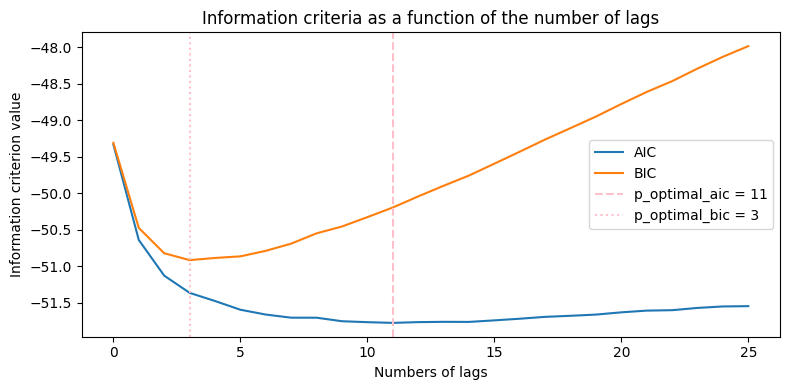

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(lags, aic_list,  label='AIC',  color='tab:blue')
plt.plot(lags, bic_list,  label='BIC',  color='tab:orange')
plt.axvline(p_optimal_aic, color='pink', linestyle='--', label=f'p_optimal_aic = {p_optimal_aic}')
plt.axvline(p_optimal_bic, color='pink', linestyle=':', label=f'p_optimal_bic = {p_optimal_bic}')
plt.xlabel("Numbers of lags")
plt.ylabel("Information criterion value")
plt.title("Information criteria as a function of the number of lags")
plt.legend()
plt.tight_layout()
plt.show()

We note that the optimal value of **$p$** differs between the AIC and BIC criteria.  
Since the optimal lag according to AIC is **$11$**, we decide to proceed with the BIC-based model using **$p = 3$**.


# **4. Fit model for AIC and BIC**

In practice, `params_AIC` contains:

- On the **"const"** row: the intercept (value at lag $0$) for each equation.
- On the **"var_Lk"** rows: the coefficient of lag $k$ of variable *var* in the equation for each dependent variable.

In [10]:
results_AIC = model.fit(p_optimal_aic)

params_AIC = results_AIC.params
A_AIC = results_AIC.coefs
B_AIC = results_AIC.intercept

results_BIC = model.fit(p_optimal_bic)

# based on the previous results, we keep only the BIC criterion matrix 
params_BIC = results_BIC.params
A_BIC = results_BIC.coefs
B_BIC = results_BIC.intercept


## **5. AIC vs BIC**

$
X(t) \;=\; A\,X(t-1) \;+\; \dots
$

$
\begin{pmatrix}
\mathrm{Vol\_lo\_bid}\\
\mathrm{Vol\_lo\_ask}\\
\mathrm{Vol\_c\_bid}\\
\mathrm{Vol\_c\_ask}\\
\mathrm{Vol\_ex\_bid}\\
\mathrm{Vol\_ex\_ask}\\
\end{pmatrix}_{t}
\;=\;
A\,
\begin{pmatrix}
\mathrm{Vol\_lo\_bid}\\
\mathrm{Vol\_lo\_ask}\\
\vdots
\end{pmatrix}_{t-1}
\;+\;\dots
$

$
\mathrm{Vol\_lo\_bid}(t)
\;=\;
a_{11}\,\mathrm{Vol\_lo\_bid}(t-1)
\;+\;
a_{12}\,\mathrm{Vol\_lo\_ask}(t-1)
\;+\;\dots
$

The heatmap displays the VAR coefficient matrices across different lags for the 6 dependent variables, with each row corresponding to one coefficient relative to an explanatory variable — resulting in 36 rows in total.

The color of each box represents the magnitude of the corresponding coefficient in the matrix: the darker the box, the higher the coefficient.

It can be observed that for almost all rows, the coefficients tend to decrease towards zero as the lag increases. This indicates that lower lags have more influence than higher lags, highlighting the predominance of short-term dependencies in the model.


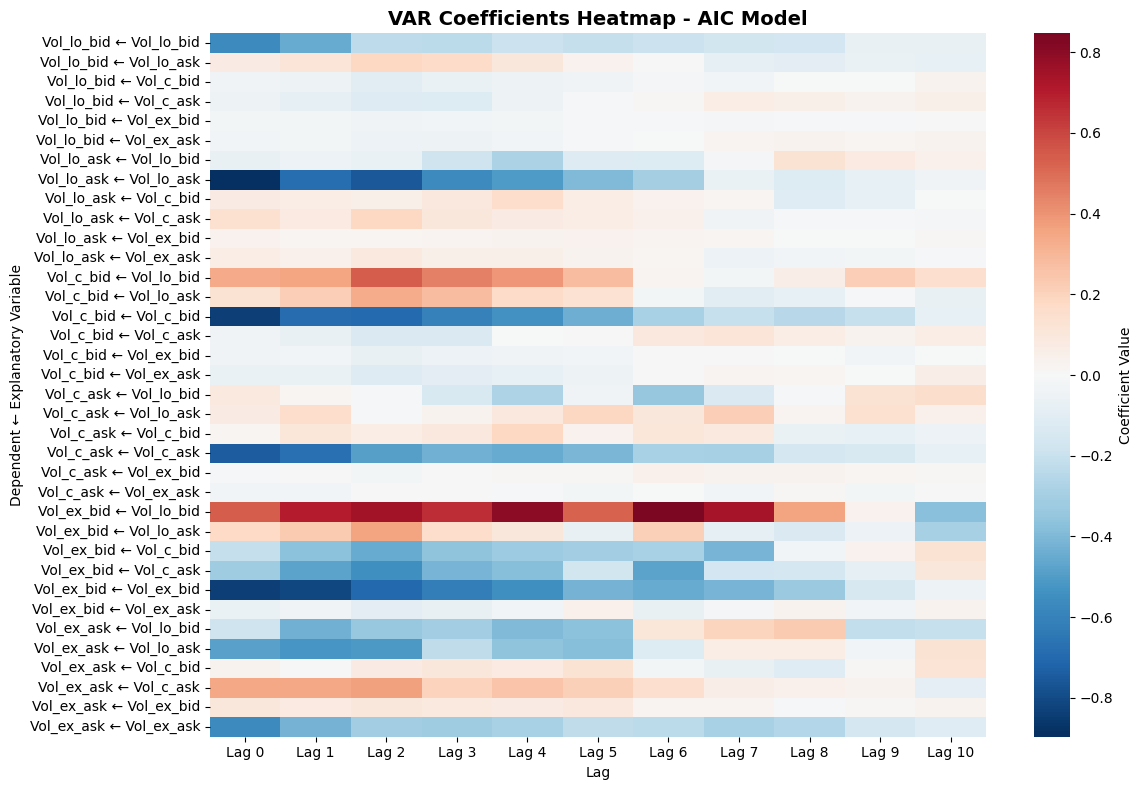

In [11]:
import seaborn as sns

def plot_coefficient_heatmap(A_matrix, model_name, figsize=(12, 8)):
    """
    Create heatmap of VAR coefficients
    
    """
    
    nb_lags, n_vars, _ = A_matrix.shape
    
    # Variable names
    var_names = ['Vol_lo_bid', 'Vol_lo_ask', 'Vol_c_bid', 'Vol_c_ask', 'Vol_ex_bid', 'Vol_ex_ask']
    
    # Create coefficient matrix for heatmap (variables × lags)
    coef_matrix = np.zeros((n_vars * n_vars, nb_lags))
    labels = []
    
    for i in range(n_vars):
        for j in range(n_vars):
            row_idx = i * n_vars + j
            for lag in range(nb_lags):
                coef_matrix[row_idx, lag] = A_matrix[lag, i, j]
            labels.append(f'{var_names[i]} ← {var_names[j]}')
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(coef_matrix, 
                xticklabels=[f'Lag {i}' for i in range(nb_lags)],
                yticklabels=labels,
                cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Coefficient Value'})
    
    plt.title(f'VAR Coefficients Heatmap - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Lag')
    plt.ylabel('Dependent ← Explanatory Variable')
    plt.tight_layout()
    plt.show()



# Heatmap visualization
plot_coefficient_heatmap(A_AIC, "AIC Model")

## **6. Checking the Stability of the VAR Model Using BIC Criteria**

We apply the ADF test manually by using the companion matrix derived from **A_BIC** (with **A_AIC** as an alternative, currently commented out).    
We decide to plot the eigenvalues on the unit circle at the end.

Process is stationary (all eigenvalues inside unit circle)


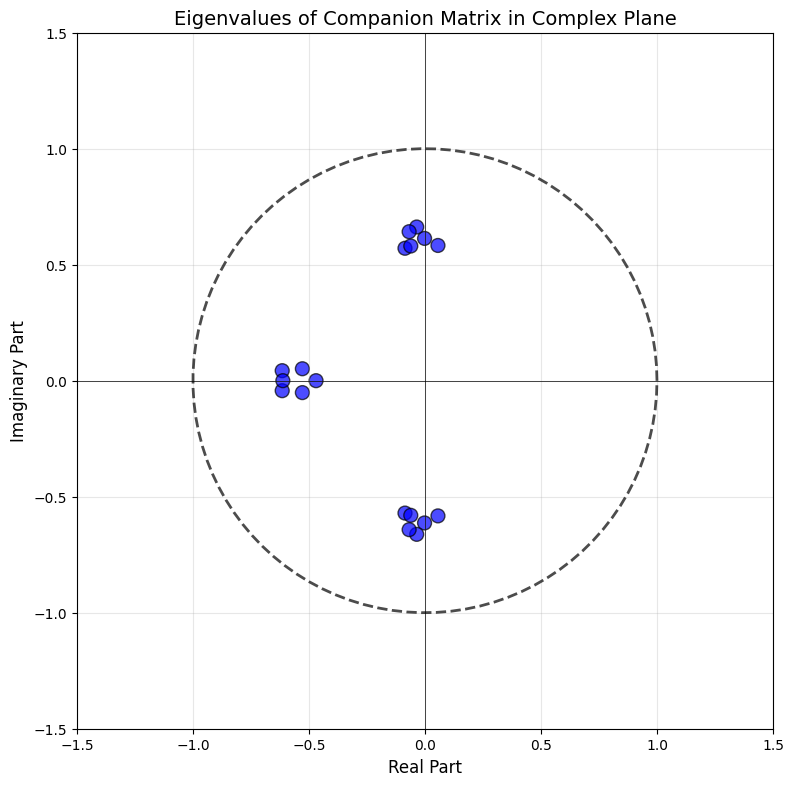

In [12]:
# initialize companion matrix
p,d, _ = A_BIC.shape  
# p,d,_ = A_AIC.shape
comp_dim = d * p
companion = np.zeros((comp_dim, comp_dim))

for k in range(p):
    companion[0:d, k*d:(k+1)*d] = A_BIC[k]  # Using A_BIC here

for block in range(1, p):
    companion[block*d:(block+1)*d, (block-1)*d:block*d] = np.eye(d)
    # companion[0:d, k*d:(k+1)*d] = A_AIC[k]

# calculate eigenvalues of the companion matrix
eigvals = np.linalg.eigvals(companion)

# check stationarity condition (all eigenvalues inside unit circle)
stationary = True
for i, eigenval in enumerate(eigvals):
    modulus = np.abs(eigenval)
    if modulus >= 1:
        stationary = False

if stationary:
    print("Process is stationary (all eigenvalues inside unit circle)")
else:
    print("Process is non-stationary (some eigenvalues outside unit circle)")

# Create visualization of eigenvalues in the complex plane
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
unit_circle_x = np.cos(theta)
unit_circle_y = np.sin(theta)
ax.plot(unit_circle_x, unit_circle_y, 'k--', linewidth=2, alpha=0.7, label='Unit Circle')

# Plot eigenvalues
real_parts = np.real(eigvals)
imag_parts = np.imag(eigvals)

# Color eigenvalues based on whether they're inside or outside unit circle
colors = ['red' if np.abs(ev) >= 1 else 'blue' for ev in eigvals]
ax.scatter(real_parts, imag_parts, c=colors, s=100, alpha=0.7, edgecolors='black')


ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('Real Part', fontsize=12)
ax.set_ylabel('Imaginary Part', fontsize=12)
ax.set_title('Eigenvalues of Companion Matrix in Complex Plane', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

# **7. Result of Our Model**

We simulate the VAR(3) model using the estimated parameters from the BIC-selected lag order.  

The VAR(3) model can be expressed as:

$X_{t} = A_1 X_{t-1} + A_2 X_{t-2} + A_3 X_{t-3} + B + \varepsilon_t$

where:  
- $X_t$ is the state vector at time $t$,  
- $A_i$ are the coefficient matrices for lag $i$,  
- $B$ is the intercept vector,  
- $\varepsilon_t \sim \mathcal{N}(0, \Sigma)$ is the white noise with covariance matrix $(\Sigma)$.

In [13]:
x_init = vars_for_var[:4].values # to appy the VAR formula we are obligated to compute X0,X1,X2

Sigma = results_BIC.sigma_u      # cov residuals
L = np.linalg.cholesky(Sigma)   # Sigma = L @ L.T

Xn = [x_init[0], x_init[1],x_init[2]]  # list simulated vectors


# we choose, for example, to simulate up to 50 time steps
horizon = 50 

for n in range(horizon):
    z = np.random.randn(6)     
    eps_t = L @ z                # eps_t a covariance Sigma (6,)

    # formula of VARI X_{n+1} = X_{n}A + B + eps
    Xn_plus_one = A_BIC[0] @ Xn[-1] \
                + A_BIC[1] @ Xn[-2] \
                + A_BIC[2] @ Xn[-3] \
                + B_BIC + eps_t
    
    Xn.append(Xn_plus_one)

We plot the simulated and actual values of Vol_lo_bid.

/var/folders/cf/vfy6jk912gbfdv5ctrf7z7fh0000gn/T/ipykernel_1267/2115049859.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index  = pd.date_range(start=start_date, periods=len(arr), freq="5T")


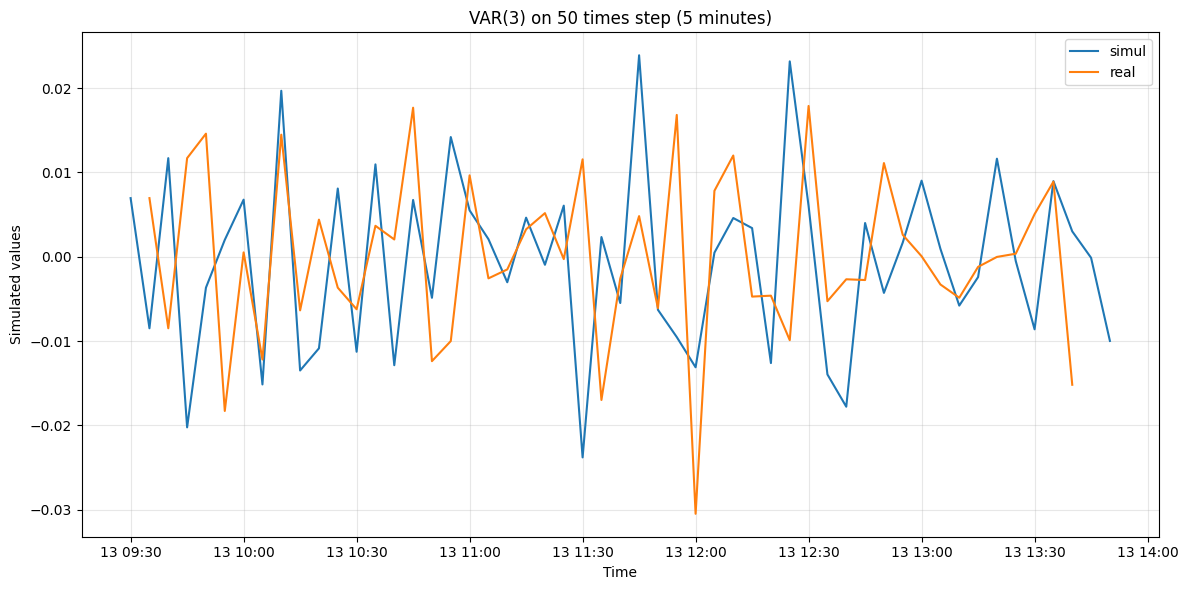

In [14]:
arr = np.vstack(Xn)
start_date  = pd.to_datetime("2017-03-13 09:30:00")
full_index  = pd.date_range(start=start_date, periods=len(arr), freq="5T")
cols = ['Vol_lo_bid','Vol_lo_ask','Vol_c_bid','Vol_c_ask','Vol_ex_bid','Vol_ex_ask']
df_sim = pd.DataFrame(arr, index=full_index, columns=cols)
plt.figure(figsize=(12, 6))
first_dates = vars_for_var.index[:horizon]
first_values = vars_for_var['Vol_lo_bid'].iloc[:horizon]
plt.plot(df_sim.index, df_sim['Vol_lo_bid'], label="simul")
plt.plot(first_dates, first_values, label="real")
plt.xlabel("Time")
plt.ylabel("Simulated values")
plt.title(f"VAR(3) on {horizon} times step (5 minutes)")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## **8. Residuals Analisys**


In time series models such as AR or VAR, the **residual** represents the portion of the data that is **not explained by the model** at a given time step.  

It is interpreted as an **error term**, **random noise**, or an **unexplained disturbance**.

We are using the **Jarque-Bera (JB) test** to determine whether a dataset follows a normal distribution, based on its **skewness** and **kurtosis**.

The JB statistic is calculated as:

$JB = \frac{n}{6} \left( S^2 + \frac{(K - 3)^2}{4} \right)$

Where:
- $n$ is the number of observations,
- $S$ is the sample skewness,
- $K$ is the sample kurtosis.

The hypotheses are:

- **Null hypothesis (H₀):** The data are normally distributed.
- **Alternative hypothesis (H₁):** The data are not normally distributed.

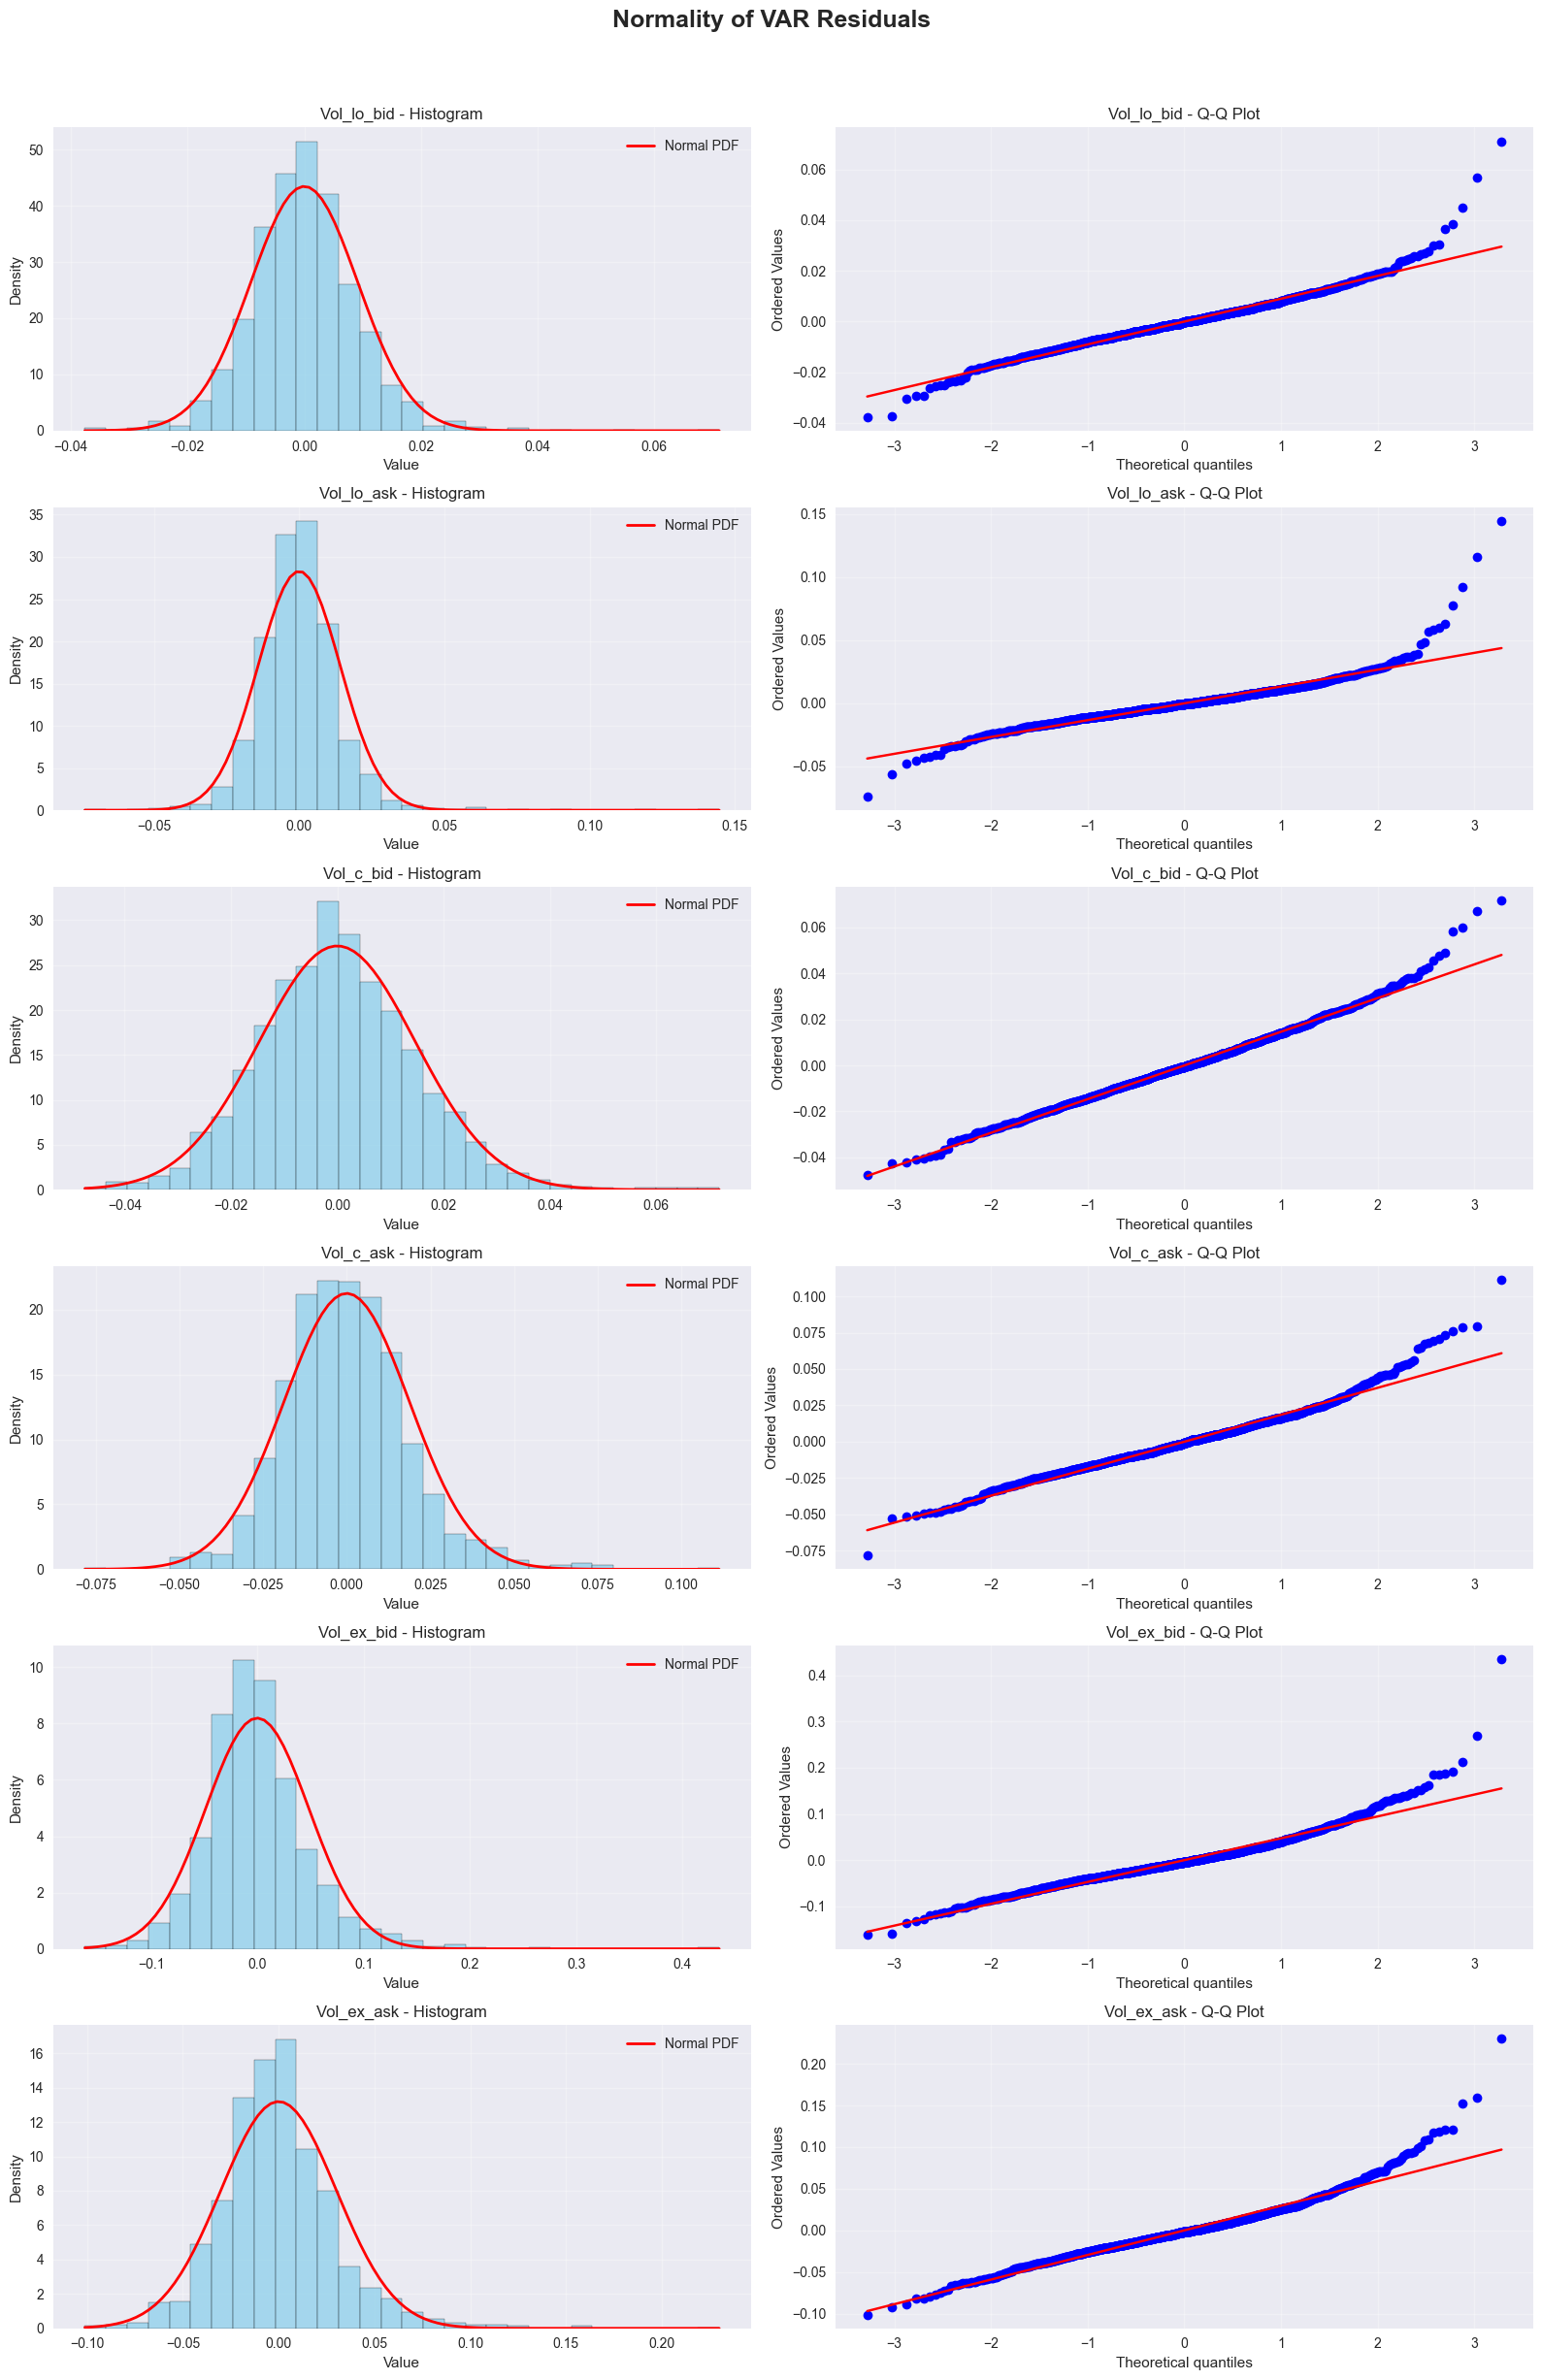

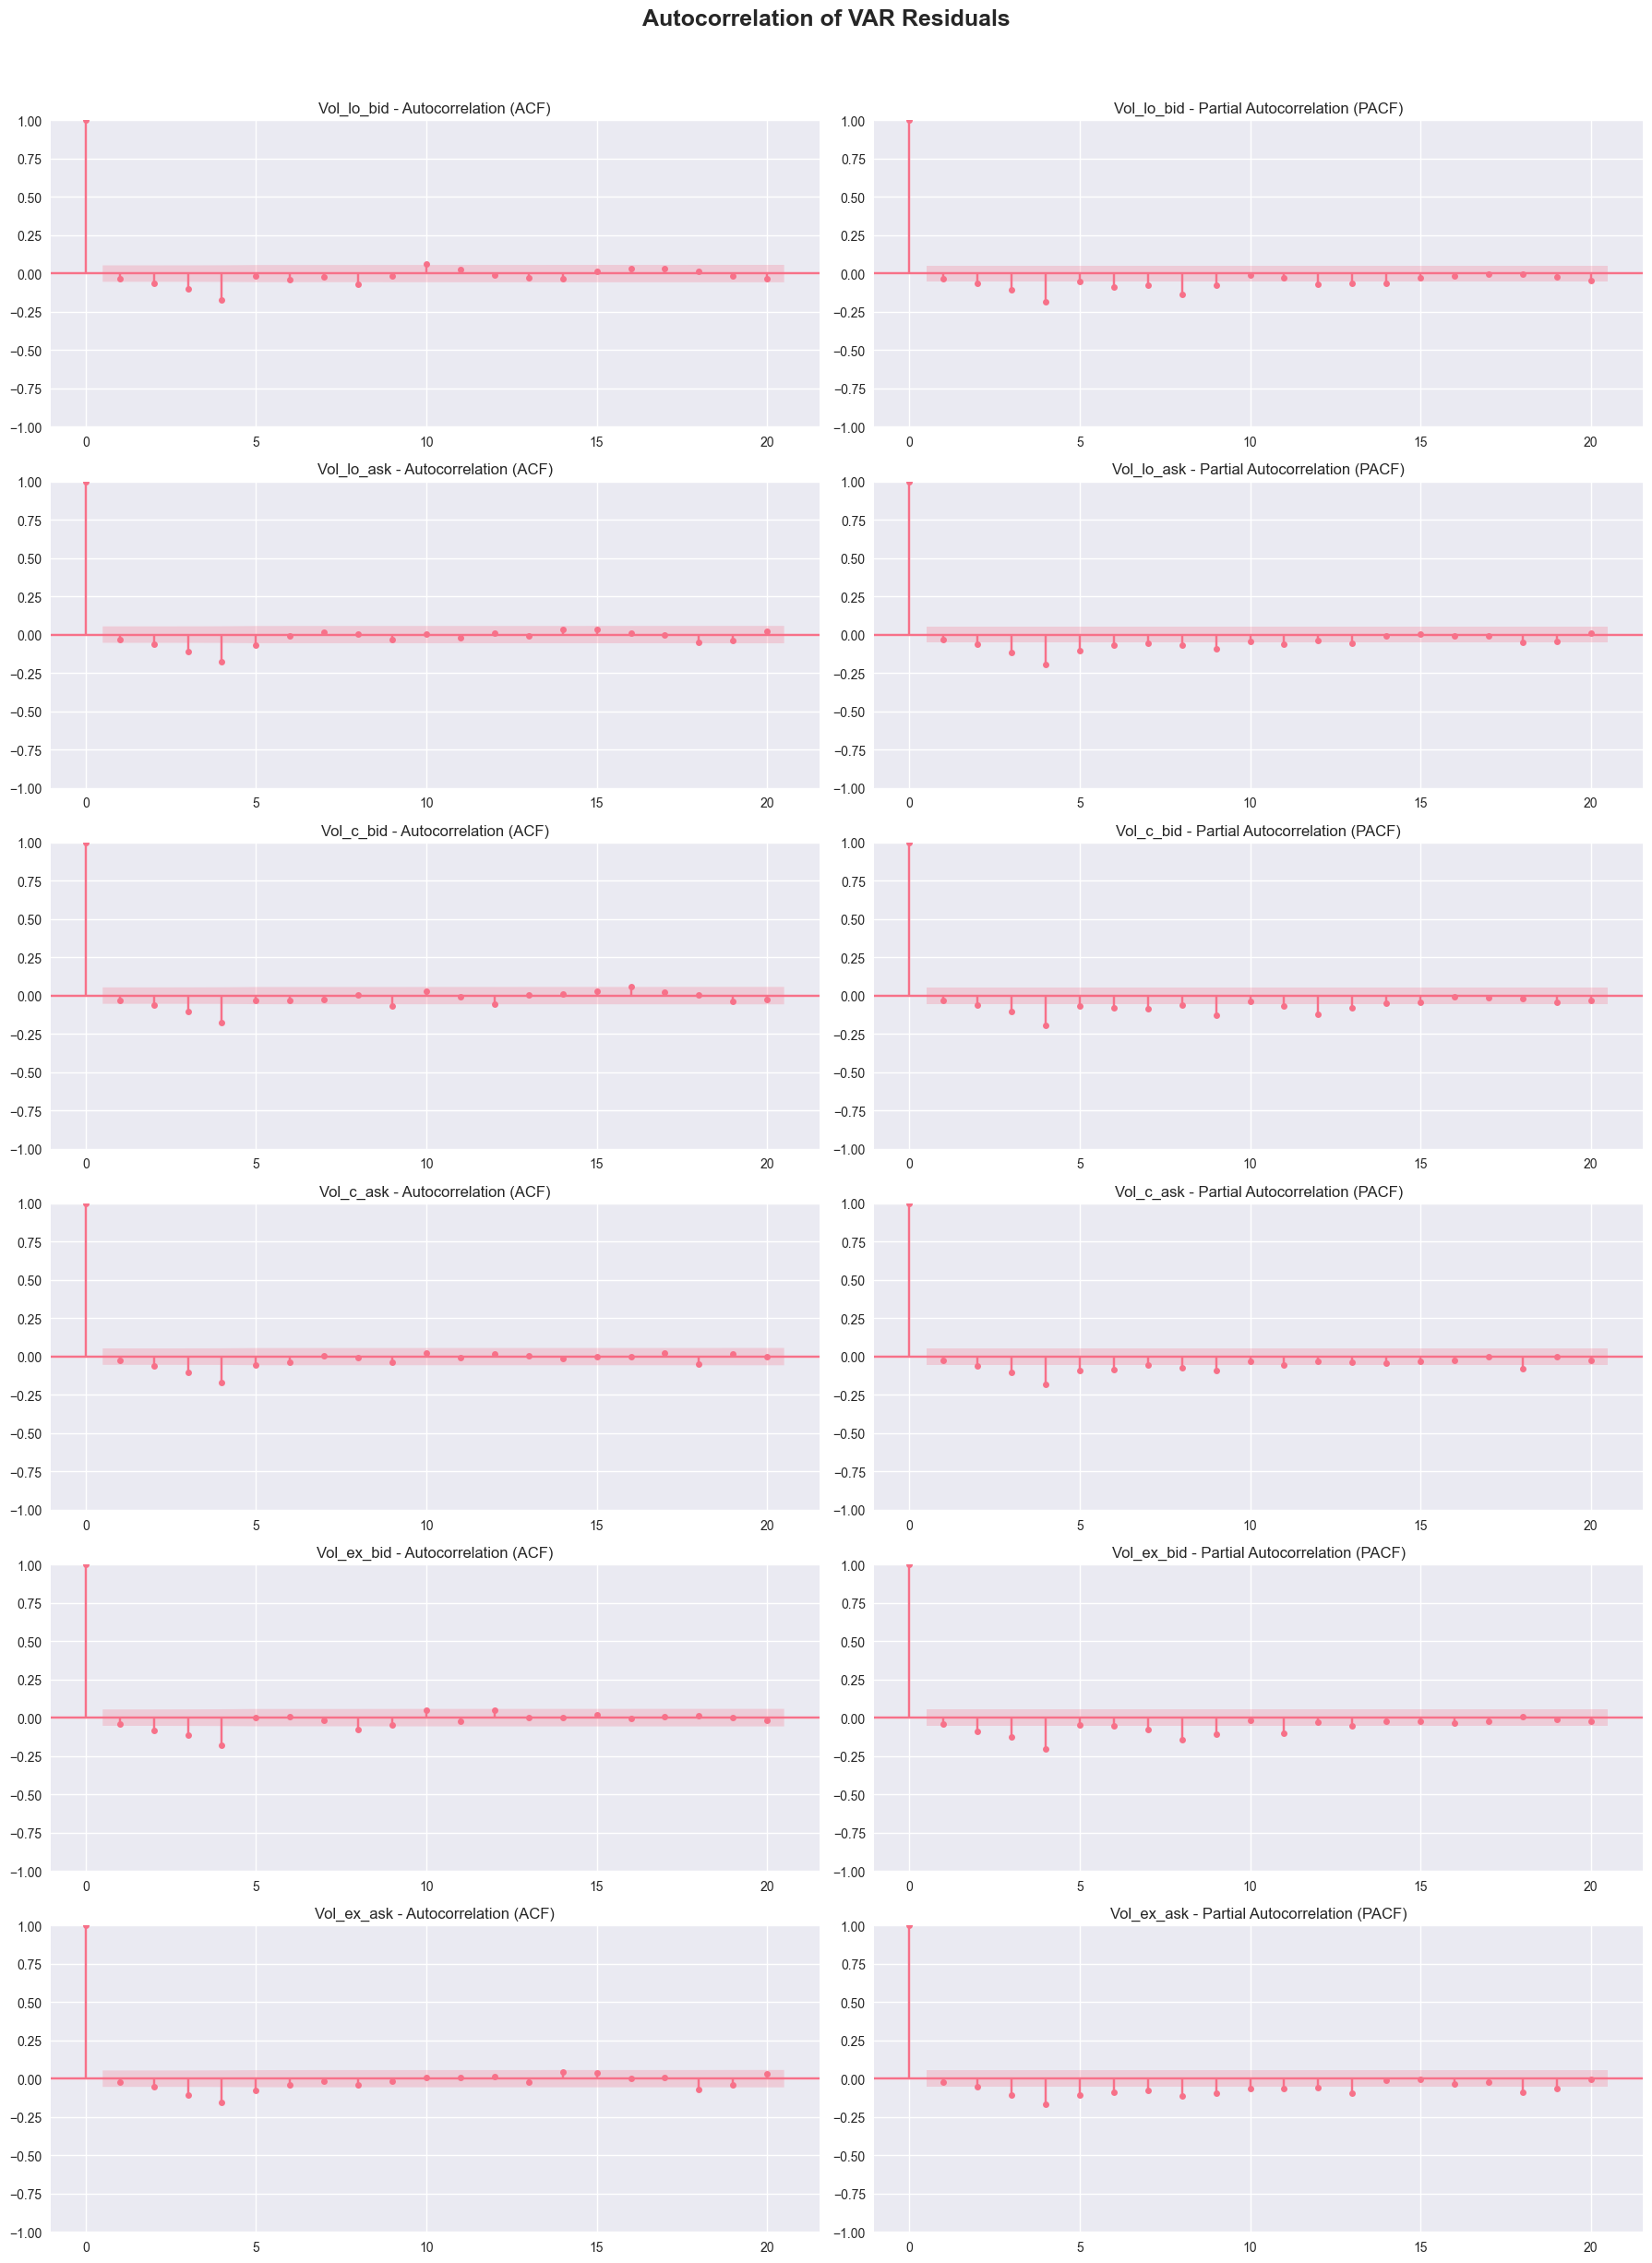

{'Vol_lo_bid':       lb_stat     lb_pvalue
 1    1.595369  2.065608e-01
 2    7.124033  2.838154e-02
 3   20.034363  1.669817e-04
 4   59.617049  3.491349e-12
 5   60.009728  1.209844e-11
 6   62.229584  1.584231e-11
 7   62.710313  4.332076e-11
 8   68.927434  8.032550e-12
 9   69.151261  2.233190e-11
 10  73.987872  7.486002e-12,
 'Vol_lo_ask':       lb_stat     lb_pvalue
 1    1.307432  2.528602e-01
 2    6.752420  3.417674e-02
 3   23.248895  3.583515e-05
 4   65.594265  1.928707e-13
 5   71.505037  4.980725e-14
 6   71.603975  1.916141e-13
 7   71.823718  6.318574e-13
 8   71.859529  2.093396e-12
 9   73.226318  3.536139e-12
 10  73.262414  1.035508e-11,
 'Vol_c_bid':       lb_stat     lb_pvalue
 1    1.246211  2.642774e-01
 2    6.239689  4.416403e-02
 3   20.330411  1.449744e-04
 4   63.016421  6.732107e-13
 5   64.563198  1.380688e-12
 6   65.993469  2.703463e-12
 7   66.822124  6.465808e-12
 8   66.884784  2.043622e-11
 9   72.925375  4.053184e-12
 10  73.997055  7.455303e-12,

In [15]:
from scipy import stats
from scipy.stats import jarque_bera 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configuring the graphs
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def analyse_residuals_var(model_var):
    """
    The function compute the result in a dict of Jarque-Bera's Test
    """
    
    # collecting residuals
    residus = model_var.resid

    variables_names = residus.columns.tolist()
    
    resultats_tests = {}

    for i, var in enumerate(variables_names): # we are testing for each value

        residus_var = residus.iloc[:, i].dropna()
        resultats_tests[var] = {}
        
        # Jarque-Bera's Test
        _, jb_pvalue = jarque_bera(residus_var)
        resultats_tests[var] = {'p_value': jb_pvalue}
    
    return resultats_tests

def graph_residuals_var(model_var):

    """ 
    We plot the histogram with normal curve,Q-Q plot and the autocorrelation graph
    """

    residus = model_var.resid
    variables_names = residus.columns.tolist()
    n_vars = len(variables_names)

    fig, axes = plt.subplots(n_vars, 2, figsize=(16, 4 * n_vars))
    fig.suptitle('Normality of VAR Residuals', fontsize=18, fontweight='bold', y=1.02)

    for i, var in enumerate(variables_names):
        residus_var = residus[var].dropna()

        # histogram with normal curve
        axes[i, 0].hist(residus_var, bins=30, density=True, alpha=0.7,
                        color='skyblue', edgecolor='black')
        x_norm = np.linspace(residus_var.min(), residus_var.max(), 100)
        y_norm = stats.norm.pdf(x_norm, residus_var.mean(), residus_var.std())
        axes[i, 0].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal PDF')
        axes[i, 0].set_title(f'{var} - Histogram')
        axes[i, 0].set_xlabel('Value')
        axes[i, 0].set_ylabel('Density')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        # Q-Q plot
        stats.probplot(residus_var, dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title(f'{var} - Q-Q Plot')
        axes[i, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Autocorrelation graphs
    fig, axes = plt.subplots(n_vars, 2, figsize=(18, 4 * n_vars))
    fig.suptitle('Autocorrelation of VAR Residuals', fontsize=18, fontweight='bold', y=1.02)

    for i, var in enumerate(variables_names):
        residus_var = residus[var].dropna()

        # ACF
        plot_acf(residus_var, ax=axes[i, 0], lags=20, alpha=0.05)
        axes[i, 0].set_title(f'{var} - Autocorrelation (ACF)')

        # PACF
        plot_pacf(residus_var, ax=axes[i, 1], lags=20, alpha=0.05)
        axes[i, 1].set_title(f'{var} - Partial Autocorrelation (PACF)')

    plt.tight_layout()
    plt.show()
    
def test_autocorrelation_residus(model_var, lags=10):

    """
    Performs the Ljung-Box test for autocorrelation on the residuals of a VAR model.
    """
    residus = model_var.resid
    
    variables_names = residus.columns.tolist()

    resultats_tests = {}
    
    for i, var in enumerate(variables_names):
        
        residus_var = residus.iloc[:, i].dropna()
        
        # Ljung-Box test
        
        ljung_box = acorr_ljungbox(residus_var, lags=lags, return_df=True)
        
        resultats_tests[var] = ljung_box


    return resultats_tests

# 1. Jarque-Bera's Test
resultats = analyse_residuals_var(results_BIC)

# 2. plot of the histogram with normal curve,Q-Q plot and the autocorrelation graph
graph_residuals_var(results_BIC)

# 3. autocorrelation
test_autocorrelation_residus(results_BIC)


# **9. Analysis of the Results**

#### **Non-Normality of Residuals**

All **6 variables have non-normal residuals**:

- **Jarque-Bera** tests report **p-values $< 0.05$** , indicating **strong evidence against normality** for all variables.

**Supporting observations:**

- **High kurtosis values** (ranging from 75 to 95):  
  → Indicates **very heavy tails** compared to a normal distribution.
- **High skewness** (positive and negative):  
  → Indicates **asymmetric distributions**.

#### **Q-Q Plots Interpretation**

Quantile-Quantile (Q-Q) plots compare sample quantiles to those of a theoretical normal distribution:

- **Perfect straight line** → Data is normally distributed.
- **Deviations from the line** → Evidence of non-normality.
- **S-shaped curve** → Indicates **heavy tails** (i.e., high kurtosis).
- **Curved ends** → Sign of **skewness**.

These plots confirm that the residuals **do not follow a Gaussian distribution**.

### **Autocorrelation Analysis**

The **autocorrelation** and **partial autocorrelation** plots of the residuals show behavior **very close to white noise**, suggesting that the VAR model is well specified.

- For **almost all variables**, the autocorrelation coefficients:
  - Stay **within the confidence bands**, and  
  - Oscillate quickly around zero.

This confirms:
- The **absence of residual autocorrelation**, and  
- The **stationarity** of the VAR process.

It also validates the choice of lag order $p$ selected using the **AIC** and **BIC** criteria.


# **10. Mean Absolute Error (MAE) and Mean Absolute Scaled Error (MASE)**

The **Mean Absolute Error (MAE)** is a common error metric used in regression and time series forecasting.

**Formula:**

$$
\text{MAE} = \frac{1}{n} \sum_{t=1}^{n} |y_t - \hat{y}_t|
$$

Where:  
- $y_t$ = actual value  
- $\hat{y}_t$ = predicted value  
- $n$ = number of observations      

**Interpretation:**  
- A **lower MAE** indicates a **better model**.  
-----

The **Mean Absolute Scaled Error (MASE)** is a scale-independent error metric commonly used in time series forecasting. It evaluates how well a model predicts compared to a naive forecast (usually using the previous time step).

**Formula:**

$$
\text{MASE} = \frac{ \frac{1}{n} \sum_{t=1}^n |y_t - \hat{y}_t| }{ \frac{1}{n-1} \sum_{t=2}^n |y_t - y_{t-1}| }
$$

Where:  
- $y_t$ = actual value  
- $\hat{y}_t$ = predicted value  
- The denominator is the mean absolute error of a naive (lag-1) model.

**Interpretation:**  
- **MASE < 1** → the model performs **better** than the naive forecast.  
- **MASE > 1** → the model performs **worse** than the naive forecast.  
- **MASE = 1** → the model is equivalent to the naive approach.


In [16]:
def mase(y_true, y_pred):
    """
    Compute the Mean Absolute Scaled Error (MASE).
    
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    

    training_series = y_true

    naive_forecast_errors = np.abs(np.diff(training_series))
    scale = np.mean(naive_forecast_errors)
    
    mae = np.mean(np.abs(y_true - y_pred))
    
    return mae / scale


def mae(y_true, y_pred):
    """
    Compute the Mean Absolute Error (MAE).
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return np.mean(np.abs(y_true - y_pred))

mae_tab = []
mase_tab = []

cols = ['Vol_lo_bid','Vol_lo_ask','Vol_c_bid','Vol_c_ask','Vol_ex_bid','Vol_ex_ask']
for c in cols:
    
    first_values = vars_for_var[c].iloc[:horizon]
    y_pred = [l for l in df_sim[c][:-3]]
    y_true = [l for l in first_values]
    mase_tab.append(mase(y_true,y_pred))
    mae_tab.append(mae(y_true,y_pred))

- The MAE value shows that the model is good
- The MASE value < 1 indicates the model performs better than the naive forecast

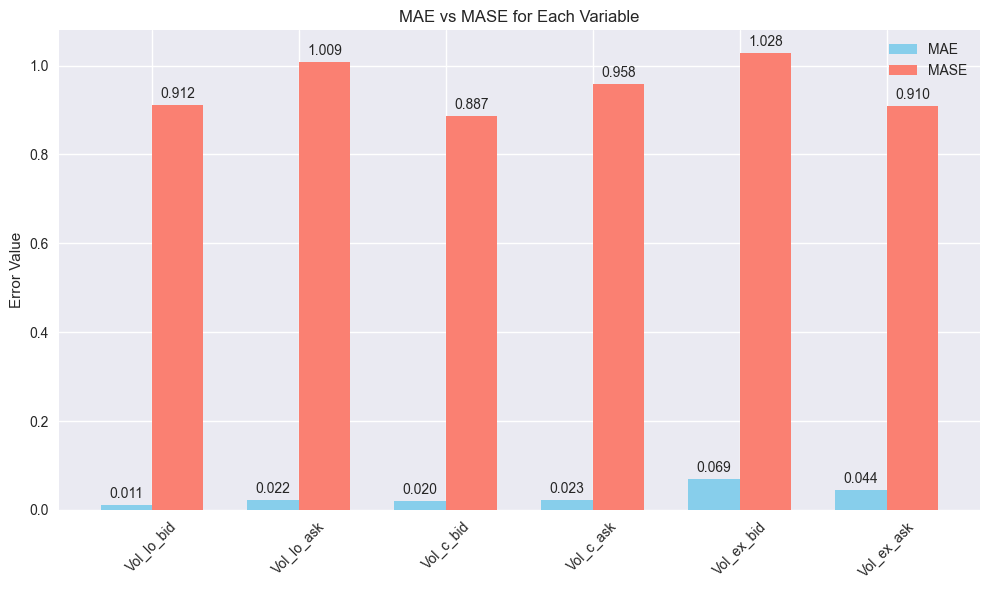

In [17]:
# Assuming `cols`, `mae_tab`, and `mase_tab` have already been computed

x = np.arange(len(cols))  # indices des variables
width = 0.35  # largeur des barres

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, mae_tab, width, label='MAE', color='skyblue')
rects2 = ax.bar(x + width/2, mase_tab, width, label='MASE', color='salmon')

# Titres et légendes
ax.set_ylabel('Error Value')
ax.set_title('MAE vs MASE for Each Variable')
ax.set_xticks(x)
ax.set_xticklabels(cols, rotation=45)
ax.legend()

# Ajoute les valeurs au-dessus des barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # décalage vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
